# Clustering Model Selection

We run a handful of clustering algorithms and hyperparameter combinations on a representative chunk of our dataset and pick the 'best'.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gp
%matplotlib inline

In [2]:
# Read in data
data = pd.read_csv('../data/features/merged.csv')

## Create training data
### ... by filtering columns

For model selection, we drop all demographic breakdown columns, keeping the total counts of each type.

In [3]:
demo_columns = ['COMPLAINTS_BLACK','COMPLAINTS_HISPANIC','COMPLAINTS_WHITE','ISR_BLACK','ISR_WHITE','ISR_HISPANIC','UOF_HISPANIC','UOF_BLACK','UOF_WHITE','CENSUS_WHITE','CENSUS_BLACK','CENSUS_HISPANIC','CENSUS_MEDIAN INCOME', 'CENSUS_TOTAL POP']
training_data = data.drop(demo_columns, axis=1)

### .. by aggregating rows

For model selection, since we're eventually clustering by beat, we'll aggregate by summing all years together.


In [4]:
training_data = training_data.drop('YEAR',axis=1).groupby(by='BEAT').agg(np.sum).reset_index(drop=True)

## Preprocess / Transform Data

In [5]:
from sklearn.preprocessing import StandardScaler
# Normalize columns
scaler = StandardScaler()
scaled_training_data = pd.DataFrame(scaler.fit_transform(training_data),\
    columns=training_data.columns)

In [6]:
from sklearn.decomposition import PCA
def generate_pca_data(dataset, n_components=None):
    if n_components is None:
        n_components = dataset.shape[1]
    pca = PCA(n_components=n_components)
    pc_dataset = pd.DataFrame(pca.fit_transform(dataset))
    pc_dataset.columns = ['PC'+str(i+1) for i in range(n_components)]
    return pc_dataset, pca

In [7]:
# Do PCA
n_features = scaled_training_data.shape[1]
pca_training_data, pca = generate_pca_data(scaled_training_data, n_features)

## Peek at PCA

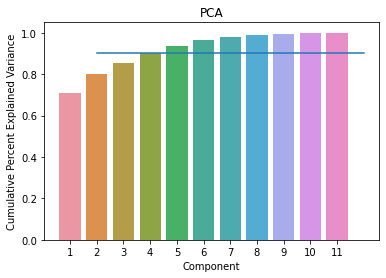

In [8]:
pca_analysis_df = pd.DataFrame({"evr":pca.explained_variance_ratio_,
                      "component": np.arange(1, pca.n_components_+1)}) \
            .assign(cum_evr = lambda x: x.evr.cumsum())
plt = sns.barplot(x="component",y="cum_evr", data=pca_analysis_df)
plt = sns.lineplot(x=pca_analysis_df.component, y=.9)
plt.set(title="PCA", xlabel="Component", ylabel="Cumulative Percent Explained Variance");

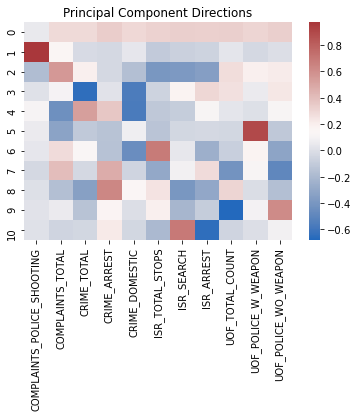

In [9]:
palette = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(pca.components_, cmap=palette, xticklabels=training_data.columns).set(title='Principal Component Directions');


From this, it looks like we can try clustering on the first 2, 4, 6 components to get 80%, 90% and 95% of the variance. 

## Pick Hyperparameters

### Number of a-priori clusters

In [10]:
# There are 272 police beats, 50 wards, 26 districts, 61 zips, 77 community areas.
param_n_clusters = [2,3,4,5,7,10,20,25,50,80]

### Number of neighbors

In [11]:
# Allow the number of neighbors to correspond to cluster sizes 
n_beats = scaled_training_data.shape[0]
param_n_neighbors = [round(np.ceil(n_beats / c)) for c in param_n_clusters]

### DBSCAN epsilon : defines neighborhood size

In [12]:
def generate_epsilons(dataset, num=6):
    """
        Return log-spaced range of distances
        based on min and max distances represented in dataset.
    """
    # Find maximum possible distance.
    data_ranges = dataset.agg([min,max])
    data_ranges = data_ranges.loc['max'] - data_ranges.loc['min']
    data_range_diag = np.sqrt(np.mean(data_ranges * data_ranges))
    # Find absolute minimum and maximum distances between points in data set
    min_dist = 9999
    max_dist = 0
    for row1 in dataset.iterrows():
        for row2 in dataset.iterrows():
            dist = 0
            for col in dataset.columns:
                dist += (row1[1][col] - row2[1][col])**2
            dist = np.sqrt(dist / len(dataset.columns))
            if row1[0] != row2[0]:
                min_dist = min(dist, min_dist)
                max_dist = max(dist, max_dist)
    # print(f'Data range: {data_range_diag:.2e}, Minimum distance: {min_dist:.2e}, Maximum distance: {max_dist:.2e}')
    return np.geomspace(min_dist*2, max_dist/2, num=num)

## Run Grid Search

In [13]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid
from util_clustering import grid_search_clustering
def hyperparameter_search(dataset):
    params_km = {'n_clusters':param_n_clusters}
    params_hagg = {'n_clusters':param_n_clusters, \
                    'affinity':['euclidean','cosine'], \
                    'linkage':['complete','average','single']}
    params_dbscan = {'eps':generate_epsilons(dataset), \
                    'min_samples':param_n_neighbors, \
                    'metric':['euclidean','cosine']}
    params_gauss = {'n_components':param_n_clusters, \
                    'n_init':[10]}
    params_spectral = [{'affinity': ['rbf'], \
                            'n_clusters':param_n_clusters}, \
                        {'affinity': ['nearest_neighbors'], \
                            'n_clusters':param_n_clusters, \
                            'n_neighbors':param_n_neighbors}]

    km_result = grid_search_clustering(KMeans(), \
        ParameterGrid(params_km), dataset, 'inertia_')

    hagg_result = grid_search_clustering(AgglomerativeClustering(), \
        ParameterGrid(params_hagg), dataset)

    dbscan_result = grid_search_clustering(DBSCAN(), \
        ParameterGrid(params_dbscan), dataset)

    gauss_result = grid_search_clustering(GaussianMixture(), \
        ParameterGrid(params_gauss), dataset, 'bic')

    spectral_result = grid_search_clustering(SpectralClustering(), \
        ParameterGrid(params_spectral), dataset)

    return pd.concat([km_result, hagg_result, dbscan_result, gauss_result, spectral_result])


In [14]:
# Run clusterings on all data in feature space
scaled_training_data_grid_results = hyperparameter_search(scaled_training_data)

# Make reduced-dimensionality dataframes
pca2_training_data, _ = generate_pca_data(scaled_training_data, 2)
pca4_training_data, _ = generate_pca_data(scaled_training_data, 2)
pca6_training_data, _ = generate_pca_data(scaled_training_data, 2)

# Run clusterings on dimension-reduced data in PCA space
pca2_data_grid_results = hyperparameter_search(pca2_training_data)
pca4_data_grid_results = hyperparameter_search(pca4_training_data)
pca6_data_grid_results = hyperparameter_search(pca6_training_data)



 6.8037872498805125, 'metric': 'cosine', 'min_samples': 14}
Training Time Elapsed: 0:00:00.004134
Training DBSCAN with: {'eps': 6.8037872498805125, 'metric': 'cosine', 'min_samples': 11}
Training Time Elapsed: 0:00:00.004256
Training DBSCAN with: {'eps': 6.8037872498805125, 'metric': 'cosine', 'min_samples': 6}
Training Time Elapsed: 0:00:00.004744
Training DBSCAN with: {'eps': 6.8037872498805125, 'metric': 'cosine', 'min_samples': 4}
Training Time Elapsed: 0:00:00.004508
Grid search completed.
Training GaussianMixture with: {'n_components': 2, 'n_init': 10}
Training Time Elapsed: 0:00:00.098542
Training GaussianMixture with: {'n_components': 3, 'n_init': 10}
Training Time Elapsed: 0:00:00.142437
Training GaussianMixture with: {'n_components': 4, 'n_init': 10}
Training Time Elapsed: 0:00:00.185763
Training GaussianMixture with: {'n_components': 5, 'n_init': 10}
Training Time Elapsed: 0:00:00.216992
Training GaussianMixture with: {'n_components': 7, 'n_init': 10}
Training Time Elapsed: 

In [15]:
# Combine all grid search results
all_grid_results = pd.concat([scaled_training_data_grid_results, pca2_data_grid_results, pca4_data_grid_results, pca6_data_grid_results], keys = ['scaled','pca2','pca4','pca6']) \
    .reset_index(level=0).rename(columns={'level_0':'Dataset'})

## Analyze Model Performance

### Pick best within KMeans

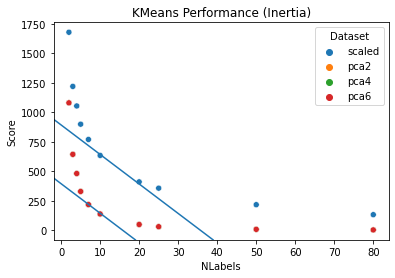

In [40]:
k_means_grid_results = all_grid_results.loc[all_grid_results['Model']=='KMeans']
g = sns.scatterplot(data=k_means_grid_results, x='NLabels', y='Score', hue='Dataset')
g.axline(xy1=(7,219), slope=-250/10)
g.axline(xy1=(10,642), slope=-250/10)
g.set(title="KMeans Performance (Inertia)");

This suggests that the optimal KMeans model uses 7 clusters if using the PCA data and 10 clusters if using the scaled data.

### Pick best within Gaussian MM

In [72]:
gauss_grid_results = all_grid_results.loc[all_grid_results['Model']=='GaussianMixture'] \
    .groupby('Dataset').sort_values('NLabels').assign(GRAD_BIC = lambda x: x['Score'].diff())
g = sns.scatterplot(data=gauss_grid_results, x='NLabels', y='GRAD_BIC', hue='Dataset')
g.set(title="Gaussian Mixture Performance (Bayesian Info Content)");

AttributeError: 'DataFrameGroupBy' object has no attribute 'sort_values'

This plot is messier, but we can say models with 7 and 10 clusters have comparable BIC scores.

### Pick Best DBSCAN

Text(0.5, 0.98, 'DBSCAN Performance')

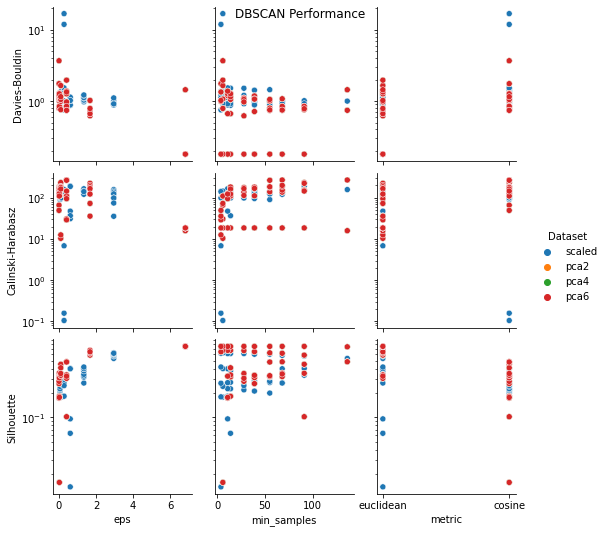

In [71]:
metric_cols = ["Davies-Bouldin","Calinski-Harabasz","Silhouette"]
dbscan_grid_results = all_grid_results.loc[all_grid_results['Model']=='DBSCAN'].reset_index(drop=True)
dbscan_params_df = pd.json_normalize(dbscan_grid_results['Params'])
dbscan_grid_results = pd.merge(dbscan_grid_results, dbscan_params_df, how='inner',left_index=True,right_index=True)
g = sns.pairplot(data=dbscan_grid_results, x_vars=['eps','min_samples','metric'], y_vars=metric_cols, hue='Dataset')
g.set(yscale='log')
g.fig.suptitle('DBSCAN Performance');

It looks like the scores are sort of constant with min_samples, and I think we should use euclidean distance not cosine. So lastly silouhette and davies get better with eps and c-h sort of gets worse, but is average. So lets pick the biggest eps.

### Pick best Heirarchical

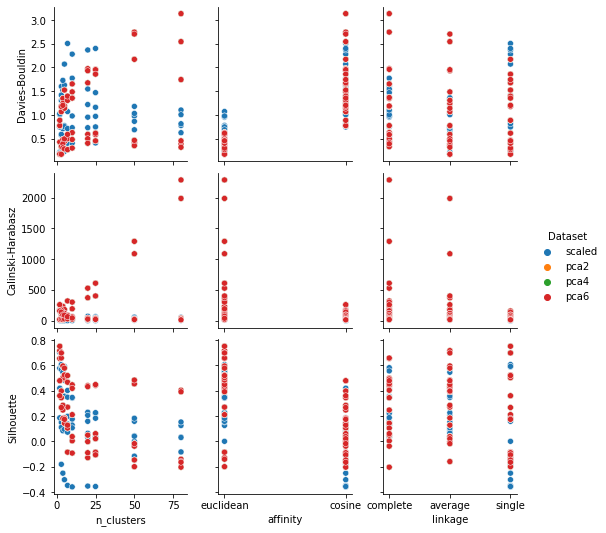

In [54]:
hagg_grid_results = all_grid_results.loc[all_grid_results['Model']=='AgglomerativeClustering'].reset_index(drop=True)
hagg_params_df = pd.json_normalize(hagg_grid_results['Params'])
hagg_grid_results = pd.concat([hagg_grid_results, hagg_params_df],axis=1)
g = sns.pairplot(data=hagg_grid_results, x_vars=['n_clusters','affinity','linkage'], y_vars=metric_cols, hue='Dataset')
g.set(title="Agglomerative Mixture Performance");

All metrics get better with fewer clusters and euclidean and affinity is sort of a wash.

In [ ]:
hagg_grid_results = all_grid_results.loc[all_grid_results['Model']=='AgglomerativeClustering'].reset_index(drop=True)
hagg_params_df = pd.json_normalize(hagg_grid_results['Params']).reset_index(drop=True)
hagg_grid_results = pd.concat([hagg_grid_results, hagg_params_df],axis=1)
g = sns.pairplot(data=hagg_grid_results, x_vars=['n_clusters','affinity','linkage'], y_vars=metric_cols, hue='Dataset')
g.set(title="Agglomerative Mixture Performance");

In [46]:

def plot_performance_metrics_scatter(grid_results):
    results = grid_results.assign(Silhouette = grid_results['Silhouette']+1)
    g = sns.pairplot(data=results, \
    y_vars="NLabels",\
    x_vars=metric_cols,\
    hue="Model")
    g.set(xscale='log')
    metric_titles = ['Lower=Better','Lower=Better','Higher=Better','KMeansLower,GaussHigher']
    for ax, title in zip(g.axes.flat, metric_titles):
        ax.set(title=title)

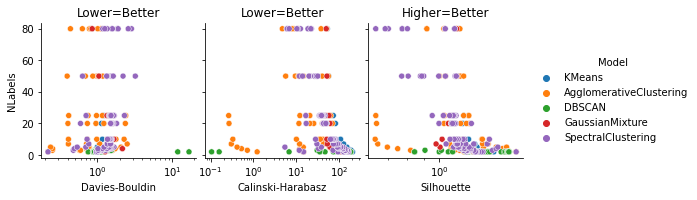

In [47]:
plot_performance_metrics_scatter(scaled_training_data_grid_results)

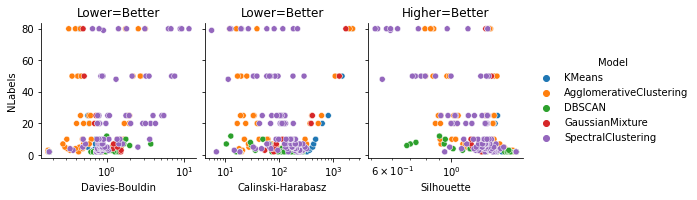

In [48]:
plot_performance_metrics_scatter(pca2_data_grid_results)

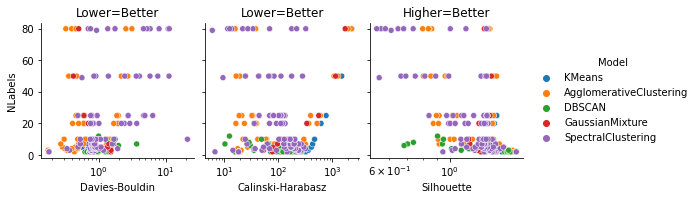

In [49]:
plot_performance_metrics_scatter(pca4_data_grid_results)

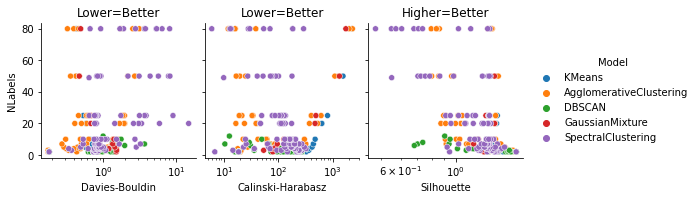

In [50]:
plot_performance_metrics_scatter(pca6_data_grid_results)

In [59]:
all_grid_results.index.name

/Users/eric/miniconda3/envs/mlpp/lib/python3.9/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


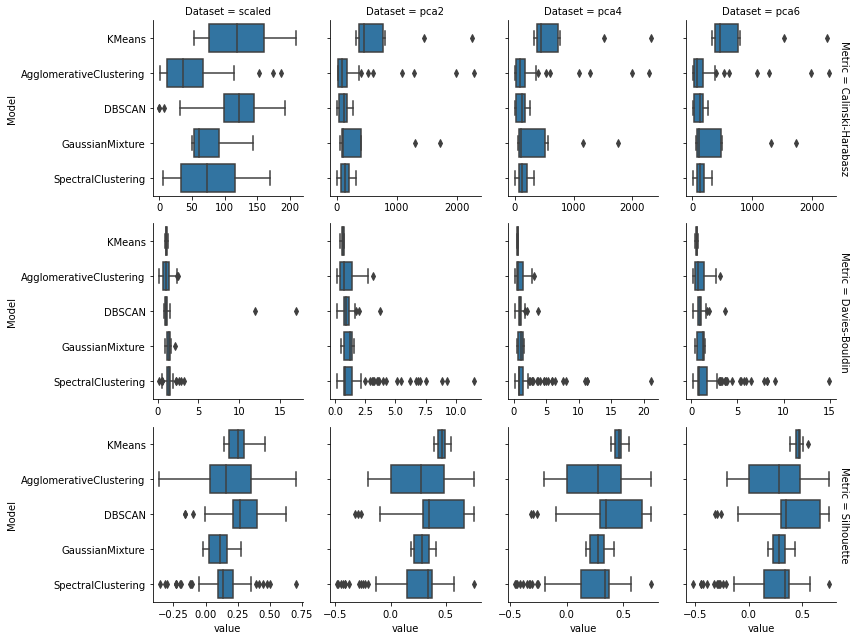

In [40]:
all_grid_results_melted = all_grid_results.drop(['Params','Time','NLabels','Labels','Score'],axis=1).melt(id_vars=['Dataset','Model'], var_name='Metric')
g = sns.FacetGrid(data=all_grid_results_melted, row='Metric', col='Dataset', sharex=False,margin_titles=True)
g.map(sns.boxplot, 'value', 'Model')

In [51]:
def assign_best_cluster_labels(dataset, grid_results):
    """
        Take the best model according to different metrics and extract the labels it produced
        Apply label vectors to original data frame
    """
    # best_labels_km = grid_results.loc[grid_results['Model']=='KMeans'] \
    #     .sort_values(by='Score', ascending=True) \
    #     .head(1)['Labels'].to_numpy()[0]
    # best_labels_gauss = grid_results.loc[grid_results['Model']=='GaussianMixture'] \
    #     .sort_values(by='Score', ascending=False) \
    #     .head(1)['Labels'].to_numpy()[0]
    best_labels_dbscore = grid_results.sort_values(by='Davies-Bouldin', ascending=True) \
        .head(1)['Labels'].to_numpy()[0]
    best_labels_vrscore = grid_results.sort_values(by='Calinski-Harabasz', ascending=True) \
        .head(1)['Labels'].to_numpy()[0]
    best_labels_silscore = grid_results.sort_values(by='Silhouette', ascending=False) \
        .head(1)['Labels'].to_numpy()[0]

    clustered = pd.concat([dataset, \
                        # pd.Series(best_labels_km, name='KMeans'), \
                        # pd.Series(best_labels_gauss, name='Gauss'), \
                        pd.Series(best_labels_dbscore, name='Davies-Bouldin'), \
                        pd.Series(best_labels_vrscore, name='Calinski-Harabasz'), \
                        pd.Series(best_labels_silscore, name='Silhouette'), \
                        ], axis=1)
    return clustered

In [52]:
# Map 'best' clusterings onto original data
pca2_clustered_data = assign_best_cluster_labels(pca2_training_data, pca2_data_grid_results)
pca4_clustered_data = assign_best_cluster_labels(pca4_training_data, pca4_data_grid_results)
pca6_clustered_data = assign_best_cluster_labels(pca6_training_data, pca6_data_grid_results)
scaled_clustered_data = assign_best_cluster_labels(scaled_training_data, scaled_training_data_grid_results)

In [66]:
scaled_clustered_data['Davies-Bouldin'].unique()

array([0, 1])